In [2]:
import sys; sys.path.append('/home/pshah/Documents/code/Vape/utils')
import funcs_pj as pjf
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import stats

In [3]:
# set up plotting settings to give real time value information
plt.rcParams['figure.figsize'] = [20,3]

## 2020-03-06: t05 (LFP and 4AP on opposite hemispheres)

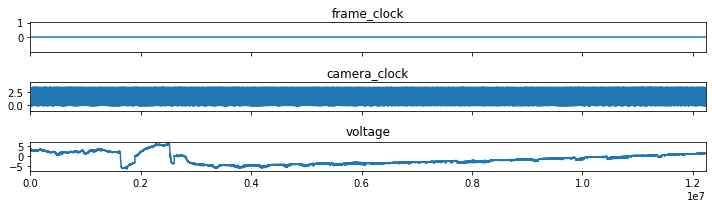

In [4]:
input_path = '/Volumes/Extreme SSD/oxford-data/2020-03-06/2020-03-06_HF82_t05.paq'

paq = pjf.paq_read(input_path, plot=True)
camera_frames = paq['data'][1]
voltage = paq['data'][2]

In [5]:
## get start frames of camera clock
# use threshold and then find large spaces in the difference between the indexes

frames = pjf.threshold_detect(camera_frames, 1.0)

# the start and stops of camera frames are where the second derivative of frames exceeds the regular values
diff = np.diff(frames)

cam_stops = frames[np.where(diff > 1000)[0]]
cam_starts = frames[np.where(diff > 1000)[0]+1]

print('Total frames:', len(frames))
print("First camera clock index:", frames[0])
print("Camera stop indexes:", cam_stops)
print("Camera start indexes: ", cam_starts)
print("last camera clock index:", frames[-1])

Total frames: 40594
First camera clock index: 35474
Camera stop indexes: []
Camera start indexes:  []
last camera clock index: 12214530


In [6]:
# work on bringing in Ca imaging rois now

t05_roi1 = np.loadtxt('/Volumes/Extreme SSD/oxford-data/2020-03-06/t05_roi1.txt', skiprows=1)[:,1]
t05_roi2 = np.loadtxt('/Volumes/Extreme SSD/oxford-data/2020-03-06/t05_roi2.txt', skiprows=1)[:,1]
t05_roi3 = np.loadtxt('/Volumes/Extreme SSD/oxford-data/2020-03-06/t05_roi3.txt', skiprows=1)[:,1]


In [7]:
# subset voltage and camera measurements to region of interest (imaging measurements taken from frame #8404 onwards)
frames=frames[8404:]

In [8]:
len(frames)

32190

In [9]:
# find the closest value in a list to the given input
sample_index, frame_index = pjf.findClosest(frames, 9000000)

In [10]:
# subset appropriately
print(sample_index) # to select voltages
print('frame of interest:', frame_index) # find the corresponding frame # (remember that for this file the ca measurement was already taken from fr no.8404 onwards)

volt_ = voltage[sample_index:] # TODO double check the subsetting here!!
t05_roi1_ = t05_roi1[(frame_index):]
t05_roi2_ = t05_roi2[(frame_index):]
t05_roi3_ = t05_roi3[(frame_index):]

9000025
frame of interest: 21475


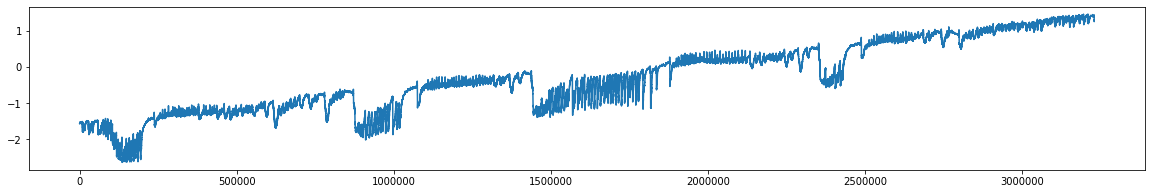

In [11]:
plt.plot(volt_)

In [12]:
# normalize ca2+ signal
baseline = np.percentile(t05_roi3_, 10); print(baseline)
t05_roi3_dff = pjf.dff(t05_roi3_,baseline)

baseline = np.percentile(t05_roi2_, 10); print(baseline)
t05_roi2_dff = pjf.dff(t05_roi2_,baseline)

baseline = np.percentile(t05_roi1_, 10); print(baseline)
t05_roi1_dff = pjf.dff(t05_roi1_,baseline)



248.22090400000002
173.43383999999998
275.87912200000005


t05_roi3_, t05_roi2, t05_roi1:
Frames: 21475 to 32190


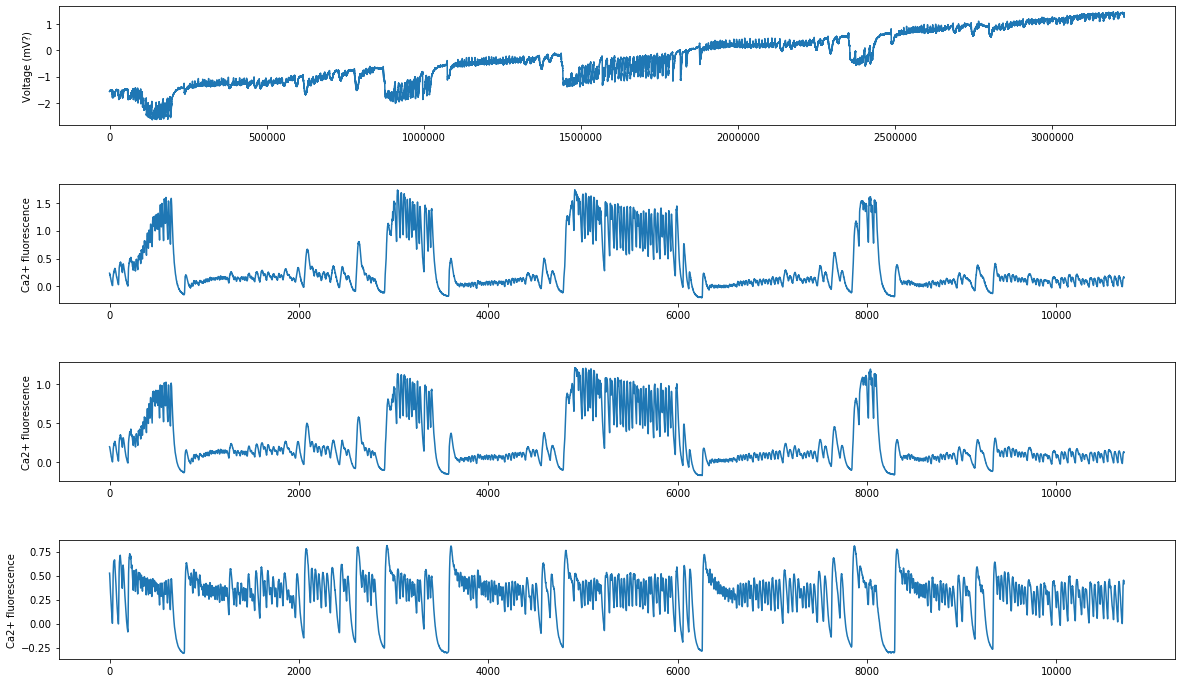

In [14]:
ca_imaging_1=t05_roi3_dff
ca_imaging_2=t05_roi2_dff
ca_imaging_3=t05_roi1_dff
print('t05_roi3_, t05_roi2, t05_roi1:')
print('Frames: %d to %d' % (frame_index ,frame_index+len(ca_imaging_1)))


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,12)); fig.subplots_adjust(hspace=0.5)
ax1.plot(volt_)
ax1.set_ylabel('Voltage (mV?)')
ax2.plot(ca_imaging_1)
ax2.set_ylabel('Ca2+ fluorescence');
ax3.plot(ca_imaging_2)
ax3.set_ylabel('Ca2+ fluorescence');
ax4.plot(ca_imaging_3)
ax4.set_ylabel('Ca2+ fluorescence');



In [15]:
# resample voltage data to same length as ca_imaging

ca_upsampled_1 = signal.resample(ca_imaging_1, len(volt_))
ca_upsampled_2 = signal.resample(ca_imaging_2, len(volt_))
ca_upsampled_3 = signal.resample(ca_imaging_3, len(volt_))


t05_roi3_, t05_roi2, t05_roi1:
Frames: 21475 to 32190


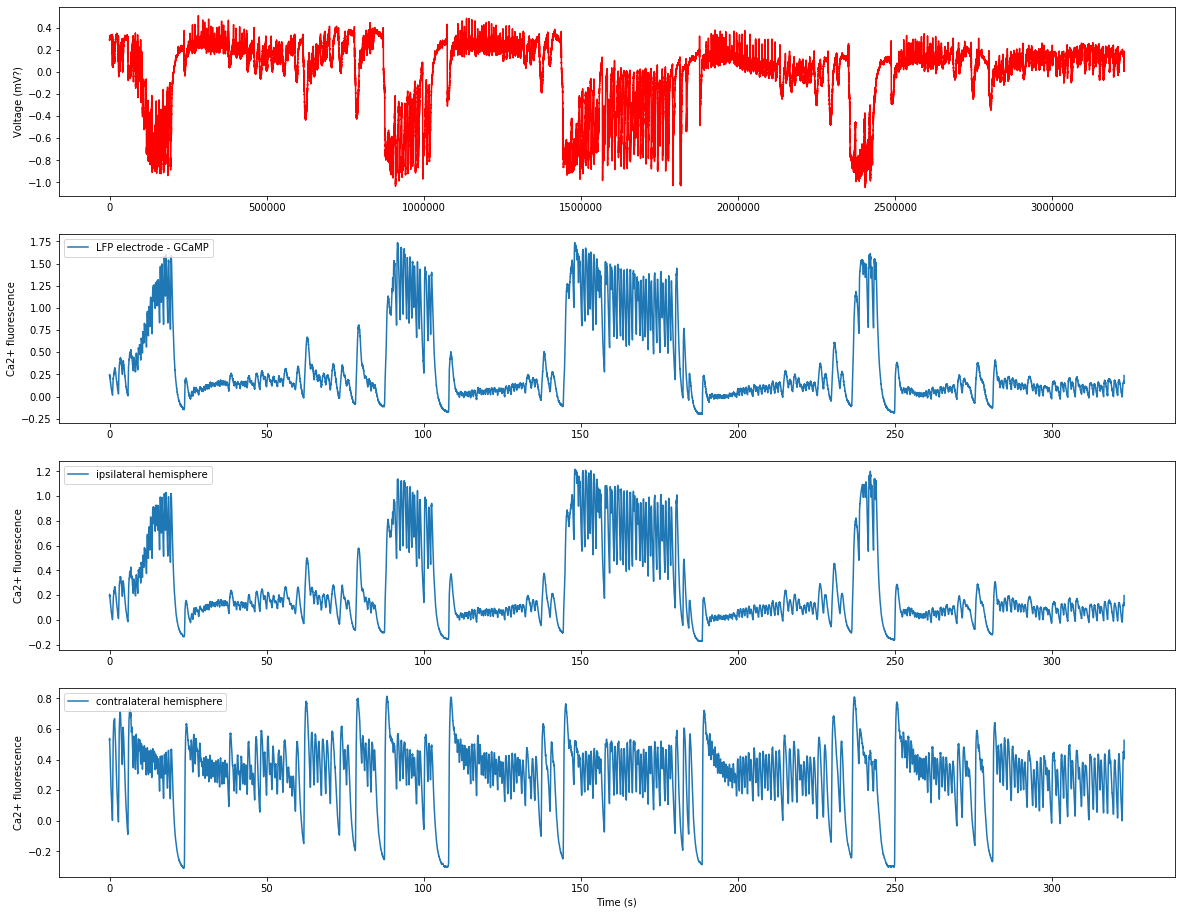

In [23]:
# plot LFP signal with GCaMP signal
print('t05_roi3_, t05_roi2, t05_roi1:')
print('Frames: %d to %d' % (frame_index ,frame_index+len(ca_imaging_1)))


# define x range in time
x = np.linspace(0,len(volt_)/10000,len(volt_))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,16)); fig.subplots_adjust(hspace=0.2)
#ax1.plot(volt_)
ax1.plot(signal.detrend(volt_), color='red')
ax1.set_ylabel('Voltage (mV?)')
ax2.plot(x, ca_upsampled_1)
ax2.set_ylabel('Ca2+ fluorescence');
ax2.legend(['LFP electrode - GCaMP'], loc=2)
ax3.plot(x, ca_upsampled_2)
ax3.set_ylabel('Ca2+ fluorescence');
ax3.legend(['ipsilateral hemisphere'], loc=2)
ax4.plot(x, ca_upsampled_3)
ax4.set_ylabel('Ca2+ fluorescence');
ax4.legend(['contralateral hemisphere'], loc=2)
ax4.set_xlabel('Time (s)');

plt.savefig('/Volumes/Extreme SSD/oxford-data/2020-03-06/test.svg', format='svg')

In [186]:
# calculate pearson correlation of LFP signal and ca_imaging signal

r_lfp_roi3 = stats.pearsonr(volt_, ca_upsampled_1); print('r| LFP vs. roi3:  %f' % r_lfp_roi3[0])
r_lfp_roi2 = stats.pearsonr(volt_, ca_upsampled_2); print('r| LFP vs. roi2:  %f' % r_lfp_roi2[0])
r_lfp_roi1 = stats.pearsonr(volt_, ca_upsampled_3); print('r| LFP vs. roi1:  %f' % r_lfp_roi1[0])
r_roi2_roi3 = stats.pearsonr(ca_upsampled_2, ca_upsampled_1); print('r| roi2 vs. roi3:  %f' % r_roi2_roi3[0])

r| LFP vs. roi3:  -0.408433
r| LFP vs. roi2:  -0.400375
r| LFP vs. roi1:  -0.143408
r| roi2 vs. roi3:  0.996814


In [160]:
r_lfp_roi1

(-0.14340781759428378, 0.0)

## 2020-02-25: LFP and 4AP on same hemisphere, next to each other